In [1]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
import tifffile as tiff
import matplotlib.pyplot as plt

In [2]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
CHECKPOINT_PATH = "./saved_models/simclr"  # Change this to your desired checkpoint path

# Custom Dataset class
class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.tiff')]
        self.resize_transform = transforms.Resize((256, 256))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")

        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0

        # Calculate sharpness for each layer
        sharpness_scores = []
        for i in range(3):
            layer = image[i]
            gy, gx = np.gradient(layer)
            gnorm = np.sqrt(gx**2 + gy**2)
            sharpness = np.average(gnorm)
            sharpness_scores.append(sharpness)

        # Find the index of the sharpest layer
        sharpest_layer_index = np.argmax(sharpness_scores)
        
        # Determine the anchor (sharpest layer) and the other two layers (augmentations)
        anchor = image[sharpest_layer_index]
        other_indices = [i for i in range(3) if i != sharpest_layer_index]
        augmentation1 = image[other_indices[0]]
        augmentation2 = image[other_indices[1]]

        # Convert to a torch tensor and add channel dimension
        anchor = torch.tensor(anchor, dtype=torch.float32).unsqueeze(0)
        aug1 = torch.tensor(augmentation1, dtype=torch.float32).unsqueeze(0)
        aug2 = torch.tensor(augmentation2, dtype=torch.float32).unsqueeze(0)
        
        # Apply resize transform
        anchor = self.resize_transform(anchor)
        aug1 = self.resize_transform(aug1)
        aug2 = self.resize_transform(aug2)

        return aug1, aug2

In [5]:
# Create the dataset
image_dir = "/home/k54739/.tiff_experiment_unsupervised_data/combined"
dataset = ImageDataset(image_dir=image_dir)
batch_size = 16

# Function to split dataset with explicit percentage
def split_dataset(dataset, val_percentage):
    val_size = int(len(dataset) * val_percentage)
    train_size = len(dataset) - val_size
    return random_split(dataset, [train_size, val_size])

# Split the dataset with 20% for validation
val_percentage = 0.2
train_dataset, val_dataset = split_dataset(dataset, val_percentage)

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=os.cpu_count())
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=os.cpu_count())



In [5]:
# Check an example to ensure correct conversion
for (aug1, aug2) in train_loader:
    print(aug1.shape, aug2.shape, aug1.dtype)
    break

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params | Mode 
-------------------------------------------
0 | convnet | ResNet | 11.5 M | train
-------------------------------------------
11.5 M    Trainable params
0         Non-trainable params
11.5 M    Total params
45.994    Total estimated model params size (MB)


Epoch 4: 100%|██████████| 19/19 [00:34<00:00,  0.55it/s, v_num=38, train_loss_step=1.43e-6, train_acc_top1_step=1.000, train_acc_top5_step=1.000, train_acc_mean_pos_step=1.000, val_loss=0.00486, val_acc_top1=1.000, val_acc_top5=1.000, val_acc_mean_pos=1.000, train_loss_epoch=0.00335, train_acc_top1_epoch=1.000, train_acc_top5_epoch=1.000, train_acc_mean_pos_epoch=1.000]

`Trainer.fit` stopped: `max_epochs=5` reached.


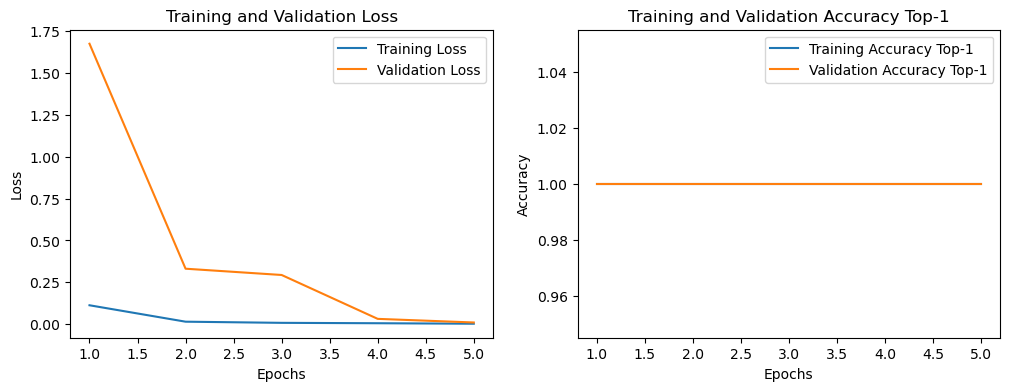

Epoch 4: 100%|██████████| 19/19 [00:34<00:00,  0.55it/s, v_num=38, train_loss_step=1.43e-6, train_acc_top1_step=1.000, train_acc_top5_step=1.000, train_acc_mean_pos_step=1.000, val_loss=0.00486, val_acc_top1=1.000, val_acc_top5=1.000, val_acc_mean_pos=1.000, train_loss_epoch=0.00335, train_acc_top1_epoch=1.000, train_acc_top5_epoch=1.000, train_acc_mean_pos_epoch=1.000]


/home/k54739/miniconda3/envs/thesis/lib/python3.12/site-packages/lightning_fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [16]:
# Define the SimCLR model class (same as in the tutorial)
class SimCLR(pl.LightningModule):
    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=50):
        super().__init__()
        self.save_hyperparameters()
        assert self.hparams.temperature > 0.0, 'The temperature must be a positive float!'

        # Load the pretrained ResNet-18 model
        self.convnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')
        
        # Modify the first convolutional layer to accept single-channel input
        # Replace the existing convolutional layer with one that accepts a single channel
        #in_channels = 1
        '''self.convnet.conv1 = nn.Conv2d(in_channels, self.convnet.conv1.out_channels, 
                                        kernel_size=self.convnet.conv1.kernel_size, 
                                        stride=self.convnet.conv1.stride, 
                                        padding=self.convnet.conv1.padding, 
                                        bias=self.convnet.conv1.bias)'''
                                        
        weight = self.convnet.conv1.weight.clone()
        self.convnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.convnet.conv1.weight.data = weight.sum(dim=1, keepdim=True)
        
        # Modify the fully connected layer
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4*hidden_dim),  # Linear layer with 4*hidden_dim output
            nn.ReLU(inplace=True),
            nn.Linear(4*hidden_dim, hidden_dim)  # Output layer with hidden_dim output
        )

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.hparams.max_epochs, eta_min=self.hparams.lr/50)
        return [optimizer], [lr_scheduler]

    def info_nce_loss(self, batch, mode='train'):
        aug1, aug2 = batch
        imgs = torch.cat((aug1, aug2), dim=0).to(self.device)  # Concatenate along the batch dimension

        # Encode all images
        feats = self.convnet(imgs).to(self.device)
        # Calculate cosine similarity
        cos_sim = nn.functional.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
        # InfoNCE loss
        cos_sim = cos_sim / self.hparams.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Logging loss
        self.log(mode + '_loss', nll, on_epoch=True, prog_bar=True)
        # Get ranking position of positive example
        comb_sim = torch.cat([cos_sim[pos_mask][:, None],  # First position positive example
                              cos_sim.masked_fill(pos_mask, -9e15)], dim=-1)
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
        # Logging ranking metrics
        self.log(mode + '_acc_top1', (sim_argsort == 0).float().mean(), on_epoch=True, prog_bar=True)
        self.log(mode + '_acc_top5', (sim_argsort < 5).float().mean(), on_epoch=True, prog_bar=True)
        self.log(mode + '_acc_mean_pos', 1 + sim_argsort.float().mean(), on_epoch=True, prog_bar=True)

        return nll

    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self.info_nce_loss(batch, mode='val')




# Define a callback to plot the training/validation loss and accuracy
class PlotLossAccuracyCallback(pl.Callback):
    def __init__(self):
        self.train_losses = []
        self.val_losses = []
        self.train_acc_top1 = []
        self.val_acc_top1 = []

    def on_train_epoch_end(self, trainer, pl_module):
        if 'train_loss' in trainer.callback_metrics:
            self.train_losses.append(trainer.callback_metrics['train_loss'].item())
        if 'train_acc_top1' in trainer.callback_metrics:
            self.train_acc_top1.append(trainer.callback_metrics['train_acc_top1'].item())

    def on_validation_epoch_end(self, trainer, pl_module):
        if 'val_loss' in trainer.callback_metrics:
            self.val_losses.append(trainer.callback_metrics['val_loss'].item())
        if 'val_acc_top1' in trainer.callback_metrics:
            self.val_acc_top1.append(trainer.callback_metrics['val_acc_top1'].item())

    def on_train_end(self, trainer, pl_module):
        # Ensure the lists are the same length
        min_len = min(len(self.train_losses), len(self.val_losses), len(self.train_acc_top1), len(self.val_acc_top1))
        self.train_losses = self.train_losses[:min_len]
        self.val_losses = self.val_losses[:min_len]
        self.train_acc_top1 = self.train_acc_top1[:min_len]
        self.val_acc_top1 = self.val_acc_top1[:min_len]

        # Plotting the loss curves
        epochs = range(1, min_len + 1)
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.train_losses, label='Training Loss')
        plt.plot(epochs, self.val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training and Validation Loss')

        # Plotting the accuracy curves
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.train_acc_top1, label='Training Accuracy Top-1')
        plt.plot(epochs, self.val_acc_top1, label='Validation Accuracy Top-1')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title('Training and Validation Accuracy Top-1')

        plt.show()


# Function to train the model
def train_simclr(batch_size, max_epochs=50, **kwargs):
    plot_callback = PlotLossAccuracyCallback()
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, 'SimCLR'),
                         accelerator="gpu" if torch.cuda.is_available() else "cpu",
                         devices=1,
                         max_epochs=max_epochs,
                         log_every_n_steps=10,  # Set this value to a lower number to see logs more frequently
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc_top5'),
                                    LearningRateMonitor('epoch'), plot_callback])

    trainer.logger._default_hp_metric = None  # Optional logging argument we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, 'SimCLR.ckpt')
    if os.path.isfile(pretrained_filename):
        print(f'Found pretrained model at {pretrained_filename}, loading...')
        model = SimCLR.load_from_checkpoint(pretrained_filename)  # Automatically loads the model with the saved hyperparameters
    else:
        pl.seed_everything(42)  # To be reproducible
        model = SimCLR(max_epochs=max_epochs, **kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = SimCLR.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)  # Load best checkpoint after training

    return model

# Train the SimCLR model
simclr_model = train_simclr(batch_size=16, hidden_dim=128, lr=5e-4, temperature=0.07, weight_decay=1e-4, max_epochs=5)


Logistic regression

In [ ]:
class LabeledImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['untreated', 'single dose', 'drug_screening']
        self.image_files = []
        self.labels = []

        for idx, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            files = [os.path.join(class_dir, file) for file in os.listdir(class_dir) if file.endswith('.tiff')]
            self.image_files.extend(files)
            self.labels.extend([idx] * len(files))
        
        self.resize_transform = transforms.Resize((256, 256))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")

        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0

        # Calculate sharpness for each layer
        sharpness_scores = []
        for i in range(3):
            layer = image[i]
            gy, gx = np.gradient(layer)
            gnorm = np.sqrt(gx**2 + gy**2)
            sharpness = np.average(gnorm)
            sharpness_scores.append(sharpness)

        # Find the index of the sharpest layer
        sharpest_layer_index = np.argmax(sharpness_scores)
        
        # Determine the anchor (sharpest layer)
        anchor = image[sharpest_layer_index]

        # Convert to a torch tensor and add channel dimension
        anchor = torch.tensor(anchor, dtype=torch.float32).unsqueeze(0)
        
        # Apply resize transform
        anchor = self.resize_transform(anchor)

        label = self.labels[idx]

        return anchor, label

# Directories for labeled data
train_image_dir = "/home/k54739/.tiff_experiment_supervised_data/train"
test_image_dir = "/home/k54739/.tiff_experiment_supervised_data/test"
/home/k54739/Data_supervised

# Create the labeled datasets
train_labeled_dataset = LabeledImageDataset(train_image_dir)
test_labeled_dataset = LabeledImageDataset(test_image_dir)

# Define DataLoaders
batch_size = 16
train_loader_labeled = DataLoader(train_labeled_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=os.cpu_count())
test_loader_labeled = DataLoader(test_labeled_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=os.cpu_count())


Feature Extraction Using Pretrained SimCLR Model:

In [ ]:
@torch.no_grad()
def prepare_data_features(model, dataloader):
    # Prepare model
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)

    # Encode all images
    feats, labels = [], []
    for batch_imgs, batch_labels in tqdm(dataloader):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)

    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)

    return torch.utils.data.TensorDataset(feats, labels)

# Extract features for train and test datasets
train_feats_simclr = prepare_data_features(simclr_model, train_loader_labeled)
test_feats_simclr = prepare_data_features(simclr_model, test_loader_labeled)


In [ ]:
class LogisticRegression(pl.LightningModule):
    def __init__(self, feature_dim, num_classes, lr, weight_decay, max_epochs=100):
        super().__init__()
        self.save_hyperparameters()
        self.model = nn.Linear(feature_dim, num_classes)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(),
                                lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                                      milestones=[int(self.hparams.max_epochs * 0.6),
                                                                  int(self.hparams.max_epochs * 0.8)],
                                                      gamma=0.1)
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode='train'):
        feats, labels = batch
        preds = self.model(feats)
        loss = nn.functional.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        self.log(mode + '_loss', loss)
        self.log(mode + '_acc', acc)
        return loss

    def training_step(self, batch, batch_idx):
        return self._calculate_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='val')

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='test')

def train_logreg(batch_size, train_feats_data, test_feats_data, model_suffix, max_epochs=100, **kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, "LogisticRegression"),
                         accelerator="gpu" if torch.cuda.is_available() else "cpu",
                         devices=1,
                         max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc'),
                                    LearningRateMonitor("epoch")],
                         enable_progress_bar=True,
                         check_val_every_n_epoch=10)
    trainer.logger._default_hp_metric = None

    # Data loaders
    train_loader = DataLoader(train_feats_data, batch_size=batch_size, shuffle=True,
                                   drop_last=False, pin_memory=True, num_workers=0)
    test_loader = DataLoader(test_feats_data, batch_size=batch_size, shuffle=False,
                                  drop_last=False, pin_memory=True, num_workers=0)

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, f"LogisticRegression_{model_suffix}.ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = LogisticRegression.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42)  # To be reproducible
        model = LogisticRegression(**kwargs)
        trainer.fit(model, train_loader, test_loader)
        model = LogisticRegression.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on train and validation set
    train_result = trainer.test(model, train_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"train": train_result[0]["test_acc"], "test": test_result[0]["test_acc"]}

    return model, result

# Train the logistic regression model
logreg_model, results = train_logreg(batch_size=16, train_feats_data=train_feats_simclr, test_feats_data=test_feats_simclr, 
                                     model_suffix="SimCLR", feature_dim=128, num_classes=3, lr=5e-4, weight_decay=1e-4, max_epochs=2)

print(f"Train Accuracy: {results['train']}, Test Accuracy: {results['test']}")


Added validation dataset and treat  test dataset and val set seperately 

In [ ]:
# Define a Custom Dataset for Labeled Data
class LabeledImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['untreated', 'single dose', 'drug_screening']
        self.image_files = []
        self.labels = []

        for idx, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            files = [os.path.join(class_dir, file) for file in os.listdir(class_dir) if file.endswith('.tiff')]
            self.image_files.extend(files)
            self.labels.extend([idx] * len(files))
        
        self.resize_transform = transforms.Resize((256, 256))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")

        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0

        # Calculate sharpness for each layer
        sharpness_scores = []
        for i in range(3):
            layer = image[i]
            gy, gx = np.gradient(layer)
            gnorm = np.sqrt(gx**2 + gy**2)
            sharpness = np.average(gnorm)
            sharpness_scores.append(sharpness)

        # Find the index of the sharpest layer
        sharpest_layer_index = np.argmax(sharpness_scores)
        
        # Determine the anchor (sharpest layer)
        anchor = image[sharpest_layer_index]

        # Convert to a torch tensor and add channel dimension
        anchor = torch.tensor(anchor, dtype=torch.float32).unsqueeze(0)
        
        # Apply resize transform
        anchor = self.resize_transform(anchor)

        label = self.labels[idx]

        return anchor, label

# Directories for labeled data
train_image_dir = "/home/k54739/.tiff_experiment_supervised_data/train"
test_image_dir = "/home/k54739/.tiff_experiment_supervised_data/test"

# Create the labeled datasets
labeled_dataset = LabeledImageDataset(train_image_dir)

# Split the labeled dataset into train and validation sets
val_percentage = 0.2
train_labeled_dataset, val_labeled_dataset = split_dataset(labeled_dataset, val_percentage)

# Define DataLoaders
batch_size = 16
train_loader_labeled = DataLoader(train_labeled_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=os.cpu_count())
val_loader_labeled = DataLoader(val_labeled_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=os.cpu_count())
test_loader_labeled = DataLoader(LabeledImageDataset(test_image_dir), batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=os.cpu_count())

# Feature Extraction Using Pretrained SimCLR Model
@torch.no_grad()
def prepare_data_features(model, dataloader):
    # Prepare model
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)

    # Encode all images
    feats, labels = [], []
    for batch_imgs, batch_labels in tqdm(dataloader):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)

    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)

    return torch.utils.data.TensorDataset(feats, labels)

# Extract features for train, validation, and test datasets
train_feats_simclr = prepare_data_features(simclr_model, train_loader_labeled)
val_feats_simclr = prepare_data_features(simclr_model, val_loader_labeled)
test_feats_simclr = prepare_data_features(simclr_model, test_loader_labeled)

# Define and Train the Logistic Regression Model
class LogisticRegression(pl.LightningModule):
    def __init__(self, feature_dim, num_classes, lr, weight_decay, max_epochs=100):
        super().__init__()
        self.save_hyperparameters()
        self.model = nn.Linear(feature_dim, num_classes)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(),
                                lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                                      milestones=[int(self.hparams.max_epochs * 0.6),
                                                                  int(self.hparams.max_epochs * 0.8)],
                                                      gamma=0.1)
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode='train'):
        feats, labels = batch
        preds = self.model(feats)
        loss = nn.functional.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        self.log(mode + '_loss', loss)
        self.log(mode + '_acc', acc)
        return loss

    def training_step(self, batch, batch_idx):
        return self._calculate_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='val')

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='test')

def train_logreg(batch_size, train_feats_data, val_feats_data, test_feats_data, model_suffix, max_epochs=100, **kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, "LogisticRegression"),
                         accelerator="gpu" if torch.cuda.is_available() else "cpu",
                         devices=1,
                         max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc'),
                                    LearningRateMonitor("epoch")],
                         enable_progress_bar=True,
                         check_val_every_n_epoch=10)
    trainer.logger._default_hp_metric = None

    # Data loaders
    train_loader = DataLoader(train_feats_data, batch_size=batch_size, shuffle=True,
                                   drop_last=False, pin_memory=True, num_workers=0)
    val_loader = DataLoader(val_feats_data, batch_size=batch_size, shuffle=False,
                                   drop_last=False, pin_memory=True, num_workers=0)
    test_loader = DataLoader(test_feats_data, batch_size=batch_size, shuffle=False,
                                  drop_last=False, pin_memory=True, num_workers=0)

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, f"LogisticRegression_{model_suffix}.ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = LogisticRegression.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42)  # To be reproducible
        model = LogisticRegression(**kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = LogisticRegression.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on validation and test set
    val_result = trainer.test(model, val_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"val": val_result, "test": test_result}
    return model, result

# Train the logistic regression model
logreg_model, results = train_logreg(batch_size=batch_size, train_feats_data=train_feats_simclr, 
                                     val_feats_data=val_feats_simclr, test_feats_data=test_feats_simclr, 
                                     model_suffix='simclr', feature_dim=train_feats_simclr.tensors[0].shape[1], 
                                     num_classes=3, lr=1e-4, weight_decay=1e-4, max_epochs=100)

print(results)


considered test set as val set

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.loggers import CSVLogger
import matplotlib.pyplot as plt
import numpy as np
import tifffile as tiff
from tqdm import tqdm
from copy import deepcopy

class LabeledImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['untreated', 'single dose', 'drug_screening']
        self.image_files = []
        self.labels = []

        for idx, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            files = [os.path.join(class_dir, file) for file in os.listdir(class_dir) if file.endswith('.tiff')]
            self.image_files.extend(files)
            self.labels.extend([idx] * len(files))
        
        self.resize_transform = transforms.Resize((256, 256))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")

        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0

        # Calculate sharpness for each layer
        sharpness_scores = []
        for i in range(3):
            layer = image[i]
            gy, gx = np.gradient(layer)
            gnorm = np.sqrt(gx**2 + gy**2)
            sharpness = np.average(gnorm)
            sharpness_scores.append(sharpness)

        # Find the index of the sharpest layer
        sharpest_layer_index = np.argmax(sharpness_scores)
        
        # Determine the anchor (sharpest layer)
        anchor = image[sharpest_layer_index]

        # Convert to a torch tensor and add channel dimension
        anchor = torch.tensor(anchor, dtype=torch.float32).unsqueeze(0)
        
        # Apply resize transform
        anchor = self.resize_transform(anchor)

        label = self.labels[idx]

        return anchor, label

# Directories for labeled data
train_image_dir = "/home/k54739/.tiff_experiment_supervised_data/train"
val_image_dir = "/home/k54739/.tiff_experiment_supervised_data/test"  # Renamed test directory to val

# Create the labeled datasets
train_labeled_dataset = LabeledImageDataset(train_image_dir)
val_labeled_dataset = LabeledImageDataset(val_image_dir)

# Define DataLoaders
batch_size = 16
train_loader_labeled = DataLoader(train_labeled_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=os.cpu_count())
val_loader_labeled = DataLoader(val_labeled_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=os.cpu_count())

@torch.no_grad()
def prepare_data_features(model, dataloader):
    # Prepare model
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)

    # Encode all images
    feats, labels = [], []
    for batch_imgs, batch_labels in tqdm(dataloader):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)

    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)

    return torch.utils.data.TensorDataset(feats, labels)

# Extract features for train and val datasets
train_feats_simclr = prepare_data_features(simclr_model, train_loader_labeled)
val_feats_simclr = prepare_data_features(simclr_model, val_loader_labeled)

class LogisticRegression(pl.LightningModule):
    def __init__(self, feature_dim, num_classes, lr, weight_decay, max_epochs=100):
        super().__init__()
        self.save_hyperparameters()
        self.model = nn.Linear(feature_dim, num_classes)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(),
                                lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                                      milestones=[int(self.hparams.max_epochs * 0.6),
                                                                  int(self.hparams.max_epochs * 0.8)],
                                                      gamma=0.1)
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode='train'):
        feats, labels = batch
        preds = self.model(feats)
        loss = nn.functional.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        self.log(mode + '_loss', loss, on_epoch=True, prog_bar=True, logger=True)
        self.log(mode + '_acc', acc, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self._calculate_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='val')

def train_logreg(batch_size, train_feats_data, val_feats_data, model_suffix, max_epochs=100, **kwargs):
    csv_logger = CSVLogger(save_dir=os.path.join(CHECKPOINT_PATH, "LogisticRegression"))
    
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, "LogisticRegression"),
                         accelerator="gpu" if torch.cuda.is_available() else "cpu",
                         devices=1,
                         max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc'),
                                    LearningRateMonitor("epoch")],
                         enable_progress_bar=True,
                         check_val_every_n_epoch=1,
                         logger=csv_logger)
    trainer.logger._default_hp_metric = None

    # Data loaders
    train_loader = DataLoader(train_feats_data, batch_size=batch_size, shuffle=True,
                              drop_last=False, pin_memory=True, num_workers=0)
    val_loader = DataLoader(val_feats_data, batch_size=batch_size, shuffle=False,
                            drop_last=False, pin_memory=True, num_workers=0)

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, f"LogisticRegression_{model_suffix}.ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = LogisticRegression.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42)  # To be reproducible
        model = LogisticRegression(**kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = LogisticRegression.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on validation set
    val_result = trainer.test(model, val_loader, verbose=False)
    result = {"val": val_result[0]["test_acc"]}

    return model, result, csv_logger

# Train the logistic regression model
logreg_model, results, csv_logger = train_logreg(batch_size=16, train_feats_data=train_feats_simclr, val_feats_data=val_feats_simclr, 
                                                 model_suffix="SimCLR", feature_dim=128, num_classes=3, lr=5e-4, weight_decay=1e-4, max_epochs=2)

print(f"Validation Accuracy: {results['val']}")

# Plot training and validation loss
metrics = csv_logger.metrics
plt.figure(figsize=(10, 5))
plt.plot(metrics['epoch'], metrics['train_loss'], label='Training Loss')
plt.plot(metrics['epoch'], metrics['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot training accuracy
plt.figure(figsize=(10, 5))
plt.plot(metrics['epoch'], metrics['train_acc'], label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training Accuracy')
plt.show()


train split corrected according to data folder

In [2]:
import os
import numpy as np
import tifffile as tiff
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.loggers import CSVLogger
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy

In [24]:
class LabeledImageDataset(Dataset):
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((256, 256))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")

        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0

        # Calculate sharpness for each layer
        sharpness_scores = []
        for i in range(3):
            layer = image[i]
            gy, gx = np.gradient(layer)
            gnorm = np.sqrt(gx**2 + gy**2)
            sharpness = np.average(gnorm)
            sharpness_scores.append(sharpness)

        # Find the index of the sharpest layer
        sharpest_layer_index = np.argmax(sharpness_scores)
        
        # Determine the anchor (sharpest layer)
        anchor = image[sharpest_layer_index]

        # Convert to a torch tensor and add channel dimension
        anchor = torch.tensor(anchor, dtype=torch.float32).unsqueeze(0)
        
        # Apply resize transform
        anchor = self.resize_transform(anchor)

        label = self.labels[idx]

        return anchor, label

def load_and_split_data(root_dir, test_size=0.2):
    classes = ['untreated', 'single_dose', 'drug_screened']
    image_files = []
    labels = []

    for idx, class_name in enumerate(classes):
        class_dir = os.path.join(root_dir, class_name)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir) if file.endswith('.tiff')]
        image_files.extend(files)
        labels.extend([idx] * len(files))
    
    # Split data into training and test sets
    train_files, test_files, train_labels, test_labels = train_test_split(
        image_files, labels, test_size=test_size, stratify=labels, random_state=42)

    return train_files, test_files, train_labels, test_labels

# Directories for labeled data
image_dir = "/home/k54739/Data_supervised"

# Load and split the data
train_files, test_files, train_labels, test_labels = load_and_split_data(image_dir, test_size=0.2)

# Create the labeled datasets
train_labeled_dataset = LabeledImageDataset(train_files, train_labels)
test_labeled_dataset = LabeledImageDataset(test_files, test_labels)

# Define DataLoaders
batch_size = 16
train_loader_labeled = DataLoader(train_labeled_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=os.cpu_count())
test_loader_labeled = DataLoader(test_labeled_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=os.cpu_count())

In [25]:
for anchor,label in train_loader_labeled:
    print(anchor.shape, label.shape, anchor.dtype)
    print(label)
    break

torch.Size([16, 1, 256, 256]) torch.Size([16]) torch.float32
tensor([0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1])


In [26]:
@torch.no_grad()
def prepare_data_features(model, dataloader):
    # Prepare model
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)

    # Encode all images
    feats, labels = [], []
    for batch_imgs, batch_labels in tqdm(dataloader):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        
        print(f"Batch features shape: {batch_feats.shape}")
        print(f"Batch labels shape: {batch_labels.shape}")
        
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)

    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)
    
    print(f"Features shape after concatenation: {feats.shape}")
    print(f"Labels shape after concatenation: {labels.shape}")

    return torch.utils.data.TensorDataset(feats, labels)

In [19]:
# Extract features for train and test datasets
train_feats_simclr = prepare_data_features(simclr_model, train_loader_labeled)
test_feats_simclr = prepare_data_features(simclr_model, test_loader_labeled)

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:08<00:00,  8.01s/it]


trying original code inbeteen variation


In [20]:
class LogisticRegression(pl.LightningModule):
    def __init__(self, feature_dim, num_classes, lr, weight_decay, max_epochs=5):
        super().__init__()
        self.save_hyperparameters()
        # Mapping from representation h to classes
        self.model = nn.Linear(feature_dim, num_classes)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(),
                                lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                                      milestones=[int(self.hparams.max_epochs * 0.6),
                                                                  int(self.hparams.max_epochs * 0.8)],
                                                      gamma=0.1)
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode='train'):
        feats, labels = batch
        preds = self.model(feats)
        loss = nn.functional.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        self.log(mode + '_loss', loss)
        self.log(mode + '_acc', acc)
        return loss

    def training_step(self, batch, batch_idx):
        return self._calculate_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='val')

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='test')

In [21]:
def train_logreg(batch_size, train_feats_data, test_feats_data, model_suffix, max_epochs=100, **kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, "LogisticRegression"),
                         accelerator="gpu" if torch.cuda.is_available() else "cpu",
                         devices=1,
                         max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc'),
                                    LearningRateMonitor("epoch")],
                         enable_progress_bar=True,
                         check_val_every_n_epoch=10)
    trainer.logger._default_hp_metric = None

    # Data loaders
    train_loader = DataLoader(train_feats_data, batch_size=batch_size, shuffle=True,
                                   drop_last=False, pin_memory=True, num_workers=0)
    test_loader = DataLoader(test_feats_data, batch_size=batch_size, shuffle=False,
                                  drop_last=False, pin_memory=True, num_workers=0)

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, f"LogisticRegression_{model_suffix}.ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = LogisticRegression.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42)  # To be reproducible
        model = LogisticRegression(**kwargs)
        trainer.fit(model, train_loader, test_loader)
        model = LogisticRegression.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on train and validation set
    train_result = trainer.test(model, train_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"train": train_result[0]["test_acc"], "test": test_result[0]["test_acc"]}

    return model, result

In [27]:


# Train the logistic regression model
logreg_model, results = train_logreg(batch_size=16, train_feats_data=train_feats_simclr, test_feats_data=test_feats_simclr, 
                                     model_suffix="SimCLR", feature_dim=128, num_classes=3, lr=5e-4, weight_decay=1e-4, max_epochs=2)

print(f"Train Accuracy: {results['train']}, Test Accuracy: {results['test']}")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params | Mode 
-----------------------------------------
0 | model | Linear | 387    | train
-----------------------------------------
387       Trainable params
0         Non-trainable params
387       Total params
0.002     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/k54739/miniconda3/envs/thesis/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


RuntimeError: mat1 and mat2 shapes cannot be multiplied (12x512 and 128x3)

variation code for val 

In [ ]:
class LogisticRegression(pl.LightningModule):
    def __init__(self, feature_dim, num_classes, lr, weight_decay, max_epochs=5):
        super().__init__()
        self.save_hyperparameters()
        self.model = nn.Linear(feature_dim, num_classes)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(),
                                lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                                      milestones=[int(self.hparams.max_epochs * 0.6),
                                                                  int(self.hparams.max_epochs * 0.8)],
                                                      gamma=0.1)
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode='train'):
        feats, labels = batch
        preds = self.model(feats)
        loss = nn.functional.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        self.log(mode + '_loss', loss, on_epoch=True, prog_bar=True, logger=True)
        self.log(mode + '_acc', acc, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self._calculate_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='val')

def train_logreg(batch_size, train_feats_data, val_feats_data, model_suffix, max_epochs=100, **kwargs):
    csv_logger = CSVLogger(save_dir=os.path.join(CHECKPOINT_PATH, "LogisticRegression"))
    
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, "LogisticRegression"),
                         accelerator="gpu" if torch.cuda.is_available() else "cpu",
                         devices=1,
                         max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc'),
                                    LearningRateMonitor("epoch")],
                         enable_progress_bar=True,
                         check_val_every_n_epoch=1,
                         logger=csv_logger)
    trainer.logger._default_hp_metric = None

    # Data loaders
    train_loader = DataLoader(train_feats_data, batch_size=batch_size, shuffle=True,
                              drop_last=False, pin_memory=True, num_workers=0)
    val_loader = DataLoader(val_feats_data, batch_size=batch_size, shuffle=False,
                            drop_last=False, pin_memory=True, num_workers=0)

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, f"LogisticRegression_{model_suffix}.ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = LogisticRegression.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42)  # To be reproducible
        model = LogisticRegression(**kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = LogisticRegression.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on validation set
    val_result = trainer.test(model, val_loader, verbose=False)
    result = {"val": val_result[0]["test_acc"]}

    return model, result, csv_logger

# Train the logistic regression model
logreg_model, results, csv_logger = train_logreg(batch_size=16, train_feats_data=train_feats_simclr, val_feats_data=test_feats_simclr, 
                                                 model_suffix="SimCLR", feature_dim=128, num_classes=3, lr=5e-4, weight_decay=1e-4, max_epochs=2)

print(f"Validation Accuracy: {results['val']}")

# Plot training and validation loss
metrics = csv_logger.metrics
plt.figure(figsize=(10, 5))
plt.plot(metrics['epoch'], metrics['train_loss'], label='Training Loss')
plt.plot(metrics['epoch'], metrics['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot training accuracy
plt.figure(figsize=(10, 5))
plt.plot(metrics['epoch'], metrics['train_acc'], label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training Accuracy')
plt.show()


Everything in one

In [29]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
import tifffile as tiff
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from pytorch_lightning.loggers import CSVLogger
from tqdm import tqdm
from copy import deepcopy

In [ ]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [33]:
CHECKPOINT_PATH = "./saved_models/simclr"  # Change this to your desired checkpoint path

# Custom Dataset class
class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.tiff')]
        self.resize_transform = transforms.Resize((256, 256))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")

        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0

        # Calculate sharpness for each layer
        sharpness_scores = []
        for i in range(3):
            layer = image[i]
            gy, gx = np.gradient(layer)
            gnorm = np.sqrt(gx**2 + gy**2)
            sharpness = np.average(gnorm)
            sharpness_scores.append(sharpness)

        # Find the index of the sharpest layer
        sharpest_layer_index = np.argmax(sharpness_scores)
        
        # Determine the anchor (sharpest layer) and the other two layers (augmentations)
        anchor = image[sharpest_layer_index]
        other_indices = [i for i in range(3) if i != sharpest_layer_index]
        augmentation1 = image[other_indices[0]]
        augmentation2 = image[other_indices[1]]

        # Convert to a torch tensor and add channel dimension
        anchor = torch.tensor(anchor, dtype=torch.float32).unsqueeze(0)
        aug1 = torch.tensor(augmentation1, dtype=torch.float32).unsqueeze(0)
        aug2 = torch.tensor(augmentation2, dtype=torch.float32).unsqueeze(0)
        
        # Apply resize transform
        anchor = self.resize_transform(anchor)
        aug1 = self.resize_transform(aug1)
        aug2 = self.resize_transform(aug2)

        return aug1, aug2
    
    
    
    
    # Create the dataset
image_dir = "/home/k54739/.tiff_experiment_unsupervised_data/combined"
dataset = ImageDataset(image_dir=image_dir)
batch_size = 16

# Function to split dataset with explicit percentage
def split_dataset(dataset, val_percentage):
    val_size = int(len(dataset) * val_percentage)
    train_size = len(dataset) - val_size
    return random_split(dataset, [train_size, val_size])

# Split the dataset with 20% for validation
val_percentage = 0.2
train_dataset, val_dataset = split_dataset(dataset, val_percentage)

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=os.cpu_count())
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=os.cpu_count())


# Define the SimCLR model class (same as in the tutorial)
class SimCLR(pl.LightningModule):
    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=50):
        super().__init__()
        self.save_hyperparameters()
        assert self.hparams.temperature > 0.0, 'The temperature must be a positive float!'

        # Load the pretrained ResNet-18 model
        self.convnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')
        
        # Modify the first convolutional layer to accept single-channel input
        # Replace the existing convolutional layer with one that accepts a single channel
        #in_channels = 1
        '''self.convnet.conv1 = nn.Conv2d(in_channels, self.convnet.conv1.out_channels, 
                                        kernel_size=self.convnet.conv1.kernel_size, 
                                        stride=self.convnet.conv1.stride, 
                                        padding=self.convnet.conv1.padding, 
                                        bias=self.convnet.conv1.bias)'''
                                        
        weight = self.convnet.conv1.weight.clone()
        self.convnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.convnet.conv1.weight.data = weight.sum(dim=1, keepdim=True)
        
        # Modify the fully connected layer
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4*hidden_dim),  # Linear layer with 4*hidden_dim output
            nn.ReLU(inplace=True),
            nn.Linear(4*hidden_dim, hidden_dim)  # Output layer with hidden_dim output
        )

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.hparams.max_epochs, eta_min=self.hparams.lr/50)
        return [optimizer], [lr_scheduler]

    def info_nce_loss(self, batch, mode='train'):
        aug1, aug2 = batch
        imgs = torch.cat((aug1, aug2), dim=0).to(self.device)  # Concatenate along the batch dimension

        # Encode all images
        feats = self.convnet(imgs).to(self.device)
        # Calculate cosine similarity
        cos_sim = nn.functional.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
        # InfoNCE loss
        cos_sim = cos_sim / self.hparams.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Logging loss
        self.log(mode + '_loss', nll, on_epoch=True, prog_bar=True)
        # Get ranking position of positive example
        comb_sim = torch.cat([cos_sim[pos_mask][:, None],  # First position positive example
                              cos_sim.masked_fill(pos_mask, -9e15)], dim=-1)
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
        # Logging ranking metrics
        self.log(mode + '_acc_top1', (sim_argsort == 0).float().mean(), on_epoch=True, prog_bar=True)
        self.log(mode + '_acc_top5', (sim_argsort < 5).float().mean(), on_epoch=True, prog_bar=True)
        self.log(mode + '_acc_mean_pos', 1 + sim_argsort.float().mean(), on_epoch=True, prog_bar=True)

        return nll

    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self.info_nce_loss(batch, mode='val')




# Define a callback to plot the training/validation loss and accuracy
class PlotLossAccuracyCallback(pl.Callback):
    def __init__(self):
        self.train_losses = []
        self.val_losses = []
        self.train_acc_top1 = []
        self.val_acc_top1 = []

    def on_train_epoch_end(self, trainer, pl_module):
        if 'train_loss' in trainer.callback_metrics:
            self.train_losses.append(trainer.callback_metrics['train_loss'].item())
        if 'train_acc_top1' in trainer.callback_metrics:
            self.train_acc_top1.append(trainer.callback_metrics['train_acc_top1'].item())

    def on_validation_epoch_end(self, trainer, pl_module):
        if 'val_loss' in trainer.callback_metrics:
            self.val_losses.append(trainer.callback_metrics['val_loss'].item())
        if 'val_acc_top1' in trainer.callback_metrics:
            self.val_acc_top1.append(trainer.callback_metrics['val_acc_top1'].item())

    def on_train_end(self, trainer, pl_module):
        # Ensure the lists are the same length
        min_len = min(len(self.train_losses), len(self.val_losses), len(self.train_acc_top1), len(self.val_acc_top1))
        self.train_losses = self.train_losses[:min_len]
        self.val_losses = self.val_losses[:min_len]
        self.train_acc_top1 = self.train_acc_top1[:min_len]
        self.val_acc_top1 = self.val_acc_top1[:min_len]

        # Plotting the loss curves
        epochs = range(1, min_len + 1)
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.train_losses, label='Training Loss')
        plt.plot(epochs, self.val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training and Validation Loss')

        # Plotting the accuracy curves
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.train_acc_top1, label='Training Accuracy Top-1')
        plt.plot(epochs, self.val_acc_top1, label='Validation Accuracy Top-1')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title('Training and Validation Accuracy Top-1')

        plt.show()


# Function to train the model
def train_simclr(batch_size, max_epochs=50, **kwargs):
    plot_callback = PlotLossAccuracyCallback()
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, 'SimCLR'),
                         accelerator="gpu" if torch.cuda.is_available() else "cpu",
                         devices=1,
                         max_epochs=max_epochs,
                         log_every_n_steps=10,  # Set this value to a lower number to see logs more frequently
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc_top5'),
                                    LearningRateMonitor('epoch'), plot_callback])

    trainer.logger._default_hp_metric = None  # Optional logging argument we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, 'SimCLR.ckpt')
    if os.path.isfile(pretrained_filename):
        print(f'Found pretrained model at {pretrained_filename}, loading...')
        model = SimCLR.load_from_checkpoint(pretrained_filename)  # Automatically loads the model with the saved hyperparameters
    else:
        pl.seed_everything(42)  # To be reproducible
        model = SimCLR(max_epochs=max_epochs, **kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = SimCLR.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)  # Load best checkpoint after training

    return model

# Train the SimCLR model
simclr_model = train_simclr(batch_size=16, hidden_dim=128, lr=5e-4, temperature=0.07, weight_decay=1e-4, max_epochs=5)



#LOGISTIC REGRESSION

class LabeledImageDataset(Dataset):
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((256, 256))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")

        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0

        # Calculate sharpness for each layer
        sharpness_scores = []
        for i in range(3):
            layer = image[i]
            gy, gx = np.gradient(layer)
            gnorm = np.sqrt(gx**2 + gy**2)
            sharpness = np.average(gnorm)
            sharpness_scores.append(sharpness)

        # Find the index of the sharpest layer
        sharpest_layer_index = np.argmax(sharpness_scores)
        
        # Determine the anchor (sharpest layer)
        anchor = image[sharpest_layer_index]

        # Convert to a torch tensor and add channel dimension
        anchor = torch.tensor(anchor, dtype=torch.float32).unsqueeze(0)
        
        # Apply resize transform
        anchor = self.resize_transform(anchor)

        label = self.labels[idx]

        return anchor, label

def load_and_split_data(root_dir, test_size=0.2):
    classes = ['untreated', 'single_dose', 'drug_screened']
    image_files = []
    labels = []

    for idx, class_name in enumerate(classes):
        class_dir = os.path.join(root_dir, class_name)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir) if file.endswith('.tiff')]
        image_files.extend(files)
        labels.extend([idx] * len(files))
    
    # Split data into training and test sets
    train_files, test_files, train_labels, test_labels = train_test_split(
        image_files, labels, test_size=test_size, stratify=labels, random_state=42)

    return train_files, test_files, train_labels, test_labels

# Directories for labeled data
image_dir = "/home/k54739/Data_supervised"

# Load and split the data
train_files, test_files, train_labels, test_labels = load_and_split_data(image_dir, test_size=0.2)

# Create the labeled datasets
train_labeled_dataset = LabeledImageDataset(train_files, train_labels)
test_labeled_dataset = LabeledImageDataset(test_files, test_labels)

# Define DataLoaders
batch_size = 16
train_loader_labeled = DataLoader(train_labeled_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=os.cpu_count())
test_loader_labeled = DataLoader(test_labeled_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=os.cpu_count())

for anchor,label in train_loader_labeled:
    print(anchor.shape, label.shape, anchor.dtype)
    break

#got output for above code:torch.Size([16, 1, 256, 256]) torch.Size([16]) torch.float32 


@torch.no_grad()
def prepare_data_features(model, dataloader):
    # Prepare model
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)

    # Encode all images
    feats, labels = [], []
    for batch_imgs, batch_labels in tqdm(dataloader):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)

    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)

    return torch.utils.data.TensorDataset(feats, labels)


# Extract features for train and test datasets
train_feats_simclr = prepare_data_features(simclr_model, train_loader_labeled)
test_feats_simclr = prepare_data_features(simclr_model, test_loader_labeled)


class LogisticRegression(pl.LightningModule):
    def __init__(self, feature_dim, num_classes, lr, weight_decay, max_epochs=5):
        super().__init__()
        self.save_hyperparameters()
        # Mapping from representation h to classes
        self.model = nn.Linear(feature_dim, num_classes)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(),
                                lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                                      milestones=[int(self.hparams.max_epochs * 0.6),
                                                                  int(self.hparams.max_epochs * 0.8)],
                                                      gamma=0.1)
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode='train'):
        feats, labels = batch
        preds = self.model(feats)
        loss = nn.functional.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        self.log(mode + '_loss', loss)
        self.log(mode + '_acc', acc)
        return loss

    def training_step(self, batch, batch_idx):
        return self._calculate_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='val')

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='test')
        
        
def train_logreg(batch_size, train_feats_data, test_feats_data, model_suffix, max_epochs=100, **kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, "LogisticRegression"),
                         accelerator="gpu" if torch.cuda.is_available() else "cpu",
                         devices=1,
                         max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc'),
                                    LearningRateMonitor("epoch")],
                         enable_progress_bar=True,
                         check_val_every_n_epoch=10)
    trainer.logger._default_hp_metric = None

    # Data loaders
    train_loader = DataLoader(train_feats_data, batch_size=batch_size, shuffle=True,
                                   drop_last=False, pin_memory=True, num_workers=0)
    test_loader = DataLoader(test_feats_data, batch_size=batch_size, shuffle=False,
                                  drop_last=False, pin_memory=True, num_workers=0)

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, f"LogisticRegression_{model_suffix}.ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = LogisticRegression.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42)  # To be reproducible
        model = LogisticRegression(**kwargs)
        trainer.fit(model, train_loader, test_loader)
        model = LogisticRegression.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on train and validation set
    train_result = trainer.test(model, train_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"train": train_result[0]["test_acc"], "test": test_result[0]["test_acc"]}

    return model, result
        
        



# Train the logistic regression model
logreg_model, results = train_logreg(batch_size=16, train_feats_data=train_feats_simclr, test_feats_data=test_feats_simclr, 
                                     model_suffix="SimCLR", feature_dim=128, num_classes=3, lr=5e-4, weight_decay=1e-4, max_epochs=2)

print(f"Train Accuracy: {results['train']}, Test Accuracy: {results['test']}")


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 42


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params | Mode 
-------------------------------------------
0 | convnet | ResNet | 11.5 M | train
-------------------------------------------
11.5 M    Trainable params
0         Non-trainable params
11.5 M    Total params
45.994    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Exception ignored in: <function _releaseLock at 0x7feb37cfc900>
Traceback (most recent call last):
  File "/home/k54739/miniconda3/envs/thesis/lib/python3.12/logging/__init__.py", line 243, in _releaseLock
    def _releaseLock():
    
KeyboardInterrupt: 


Epoch 0:   0%|          | 0/19 [00:00<?, ?it/s]                            

IsADirectoryError: [Errno 21] Is a directory: '/home/k54739'